In [11]:
print("start import")
import logging
import os
import random
print(1)
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
print(2)
from omegaconf import DictConfig, OmegaConf
from torch import nn
import iecdt_lab
import tqdm
from typing import Optional
print("imported")

start import
1
2
imported


In [12]:
def plot_reconstructions(batch, reconstructions, data_stats, max_images=8, normalise=True):
    fig, axes = plt.subplots(2, max_images, figsize=(15, 5))
    batch, reconstructions = batch[:max_images], reconstructions[:max_images]
    for i, (img, recon) in enumerate(zip(batch, reconstructions)):
        img = img.permute(1, 2, 0).cpu().numpy()
        recon = recon.permute(1, 2, 0).cpu().numpy()
        if normalise:
            img = img * data_stats["rgb_std"] + data_stats["rgb_mean"]
            recon = recon * data_stats["rgb_std"] + data_stats["rgb_mean"]
        axes[0, i].imshow(img)
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")
        axes[1, i].imshow(recon)
        axes[1, i].set_title("Reconstruction")
        axes[1, i].axis("off")

    fig.tight_layout()
    return fig


def validation(cfg, model, test_data_loader, data_stats, normalise=True):
    model.eval()
    running_mse = 0
    num_batches = len(test_data_loader)
    with torch.no_grad():
        for i, (batch, _) in enumerate(test_data_loader):
            batch = batch.to(cfg.device)
            loss, reconstructions = model.batch_loss(batch, return_reconstructions=True, beta=cfg.vae_beta)
            running_mse += loss.cpu().numpy()
            

            if i == 0:
                fig = plot_reconstructions(batch, reconstructions, data_stats, normalise=normalise)

            if cfg.smoke_test and i == 10:
                num_batches = i + 1
                break

    val_mse = running_mse / num_batches
    return fig, val_mse

In [13]:
def plot_single(input_tensor: torch.Tensor, cfg: DictConfig, data_stats: dict, axis, title: Optional[str] = None):
    if cfg.normalise:
        input_tensor = input_tensor * torch.Tensor(data_stats["rgb_std"]).view(3, 1, 1) + torch.Tensor(data_stats["rgb_mean"]).view(3, 1, 1)
    axis.imshow(input_tensor.permute(1, 2, 0))
    axis.axis("off")
    if title is not None:
        axis.set_title(title)

In [16]:
def plot_all(folder_path_in: str, is_VAE: bool = True, evidence: int = 3):
    folder_path = f"{folder_path_in}/multiruns/" 
    # for each run in the folder for the latest attempt
    # find all non hidden folders in the folder path and select the newest
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir() and not f.name.startswith('.')]
    latest_subfolder = max(subfolders, key=os.path.getmtime)

    # get the paths for all subfolders in the latest_subfolder
    sub_subfolders = [f.path for f in os.scandir(latest_subfolder) if f.is_dir() and not f.name.startswith('.')]
    sub_subfolders = list(sorted(sub_subfolders, key=lambda x: int(os.path.basename(x))))
    fig, axs = plt.subplots(len(sub_subfolders), 3 * evidence)
    
    pbar = tqdm.tqdm(enumerate(sub_subfolders), total=len(sub_subfolders))
    for run_number, run_folder in pbar:
        # load config
        run_config = OmegaConf.load(f"{run_folder}/.hydra/config.yaml")

        # prepare transforms
        data_stats = np.load(run_config.train_rgb_stats)
        if run_config.normalise:
            data_transforms = torchvision.transforms.Compose(
                [
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        mean=data_stats["rgb_mean"], std=data_stats["rgb_std"]
                    ),
                ]
            )
        else:
            data_transforms = torchvision.transforms.Compose(
                [
                    torchvision.transforms.ToTensor(),
                ]
            )
        
        # create dataloader
        train_data_loader, val_data_loader = iecdt_lab.data_loader.get_data_loaders(
            tiles_path=run_config.tiles_path,
            train_metadata=run_config.train_metadata,
            val_metadata=run_config.val_metadata,
            batch_size=evidence,
            data_transforms=data_transforms,
            dataloader_workers=run_config.dataloader_workers,
        )

        if is_VAE:
            long_model = iecdt_lab.VAE.CNNVariationalAutoencoder(latent_dim=run_config.latent_dim, lim_decoder=run_config.lim_decoder)
        else:
            long_model = iecdt_lab.autoencoder.CNNAutoencoder(latent_dim=run_config.latent_dim)

        longest_trained_path = f"{run_folder}/model.pth"
        long_model.load_state_dict(torch.load(longest_trained_path, weights_only=True))
        long_model = long_model.to(run_config.device)

        if is_VAE:
            best_val_model = iecdt_lab.VAE.CNNVariationalAutoencoder(latent_dim=run_config.latent_dim, lim_decoder=run_config.lim_decoder)
        else:
            best_val_model = iecdt_lab.autoencoder.CNNAutoencoder(latent_dim=run_config.latent_dim)

        best_val_path = f"{run_folder}/best_model.pth"
        if not os.path.exists(best_val_path):
            print(f"Best validation model not found for run {run_folder}")
            continue
        best_val_model.load_state_dict(torch.load(best_val_path, weights_only=True))
        best_val_model = best_val_model.to(run_config.device)

        input_images = next(iter(val_data_loader))[0]
        with torch.no_grad():
            long_output = long_model(input_images)
            best_val_output = best_val_model(input_images)
        # ignore the vae distribution
        if is_VAE:
            long_output = long_output[0]
            best_val_output = best_val_output[0]

        for single_evidence in range(evidence):
            plot_single(input_images[single_evidence], run_config, data_stats, axs[run_number][3 * single_evidence], title="original")
            plot_single(long_output[single_evidence], run_config, data_stats, axs[run_number][3 * single_evidence + 1], title="most trained")
            plot_single(best_val_output[single_evidence], run_config, data_stats, axs[run_number][3 * single_evidence + 2], title="highest validation")

    

100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


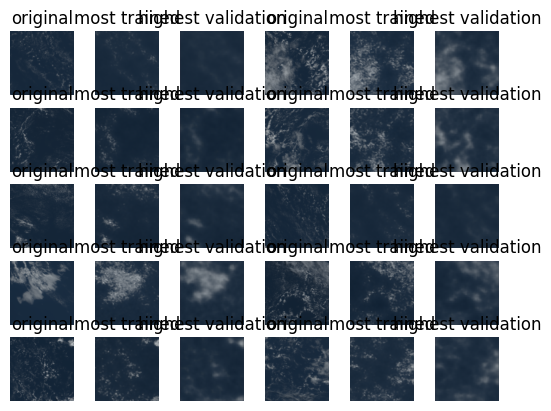

In [17]:
plot_all("/home/users/jfrom/iecdt_bjd_cloud_behaviour/logs/vae_no_normalise", evidence=2)